In [1]:
# Import modules

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as si

import astropy.constants as con
import astropy.units as unt

import pymsg

# Set plot parameters

plt.rcParams.update({'font.size': 12})

In [2]:
# Create SpecGrid object

specgrid = pymsg.SpecGrid('sg-6678.h5')

In [3]:
def synthesize_spectrum(lam, d, bruce_file, specgrid):
    
    # Open the BRUCE output file and read data

    with si.FortranFile(bruce_file, 'r') as f:
        
        # Read header
        
        record = f.read_record('<i4', '<f4')
    
        n_vis = record[0][0]
        time = record[1][0]
        
        # Read element data

        Teff = np.empty(n_vis)
        logg = np.empty(n_vis)
        A_proj = np.empty(n_vis)
        V_proj = np.empty(n_vis)
        mu = np.empty(n_vis)
    
        for i in range(n_vis):
            
            Teff[i], V_proj[i], dA_proj[i], g, mu[i] = f.read_reals('<f4')
            logg[i] = np.log10(g)+2

    # Set up the photospheric parameters dict

    x = {'Teff': Teff, 'log(g)': logg}

    # Set up the element redshifts (note that BRUCE 
    # follows the convention that a positive V_proj 
    # represents motion toward the observer)

    z = -V_proj*unt.km/unt.s / con.c

    # Set up the element solid angles

    dOmega = dA_proj/d**2

    # Evaluate the irradiance

    F_obs = specgrid.irradiance(x, mu, dOmega, z, lam)

    # Return the time and irradiance
    
    return time, F_obs

In [6]:
# Set up parameters (the choice of distance is arbitrary)

d = 10 * con.pc.value

lam = np.linspace(6673, 6682, 101)
lam_c = 0.5*(lam[:-1] + lam[1:])

n_time = 20

# Evaluate spectra

time = []
F_obs = []

for i in range(n_time):
    
    bruce_file = f'elements-{i+1:03d}'
    
    result = synthesize_spectrum(lam, 10*con.pc.value, bruce_file, specgrid)

    time += [result[0]]
    F_obs += [result[1]]

Text(0, 0.5, 'Flux (10^-8 erg/cm^2/s/Angstrom)')

<Figure size 640x480 with 0 Axes>

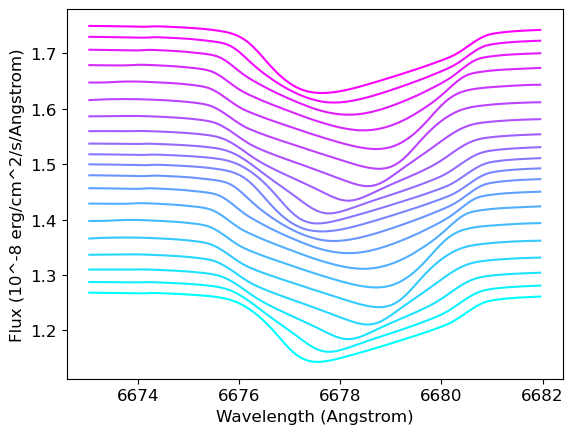

In [5]:
# Plot spectra

plt.figure()

cmap = mpl.colormaps['cool']

fig = plt.figure()

offset=0.2*(np.max(F_obs[0]) - np.min(F_obs[0]))

for i in range(n_time):
    
    plt.plot(lam_c, 1E8*(F_obs[i]+i*offset), color=cmap(i/(n_time-1)))

plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (10^-8 erg/cm^2/s/Angstrom)')